In [1]:
#seleção de atributos
#saber escolher os melhores atributos é necessario pra fugir de atributos redundantes
#Filter Method: Seleciona as varáveis antes de serem colocadas no modelo como base em algum criterio relativo a propria variavel
#Wrapper Method: Escolhe um subconjunto de variaveis, aplica o modelo e então avalia a qualidade

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
#base de dados spotify
#informações sobre musicas
df = pd.read_csv('c:/csv/spotify/songs_normalize.csv')
df.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop


In [3]:
#selecionando variaveis numericas
caracteristicas = ['danceability', 'energy', 'key', 'loudness', 'mode', 
                   'speechiness', 'acousticness', 'instrumentalness', 
                   'liveness', 'valence', 'tempo',]

In [4]:
from sklearn import preprocessing

In [5]:
#preprocessando valore pra ficar na escala de 0 a 1
x = df[caracteristicas].values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled)
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.735225,0.825230,0.090909,0.744639,0.0,0.037084,0.307363,0.000018,0.401082,0.915499,0.232272
1,0.360520,0.891961,0.000000,0.770630,1.0,0.046310,0.010534,0.000000,0.710162,0.690876,0.588118
2,0.472813,0.467217,0.636364,0.568584,1.0,0.010492,0.177238,0.000000,0.276007,0.256605,0.509441
3,0.498818,0.908908,0.000000,0.812877,0.0,0.042330,0.026928,0.000014,0.391461,0.541127,0.397615
4,0.573286,0.924796,0.727273,0.776164,0.0,0.051375,0.041784,0.001056,0.075767,0.899454,0.746771


In [6]:
df_scaled.columns = caracteristicas
df_scaled.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.735225,0.825230,0.090909,0.744639,0.0,0.037084,0.307363,0.000018,0.401082,0.915499,0.232272
1,0.360520,0.891961,0.000000,0.770630,1.0,0.046310,0.010534,0.000000,0.710162,0.690876,0.588118
2,0.472813,0.467217,0.636364,0.568584,1.0,0.010492,0.177238,0.000000,0.276007,0.256605,0.509441
3,0.498818,0.908908,0.000000,0.812877,0.0,0.042330,0.026928,0.000014,0.391461,0.541127,0.397615
4,0.573286,0.924796,0.727273,0.776164,0.0,0.051375,0.041784,0.001056,0.075767,0.899454,0.746771


In [7]:

from sklearn.cluster import KMeans
from sklearn import metrics
from itertools import permutations
from time import time

perm = permutations(caracteristicas, 3)
output = list(set(map(lambda x: tuple(sorted(x)),perm)))

In [8]:
# codigo que pega todas as variaveis possiveis  
# vai rodar o algoritmo K-means, pra pegar o valor de K e definir o melhor valor olhando a metrica da silhueta
ls_metrics = []
t0 = time()
for p in output[:50]:#só usando uma parte das variaveis
    X_ = df_scaled[list(p)]
    for i in range(2,6):#pegando valor de k de 2 a 5 pra ser curto
        kmeans_model = KMeans(n_clusters=i, 
                              random_state=42, 
                              max_iter=100).fit(X_)
        labels = kmeans_model.labels_
        silhueta = metrics.silhouette_score(X_, labels, metric='euclidean')
        ls_metrics.append([list(p), i, silhueta])

print(f"concluido em {time() - t0:.3f} s")

#levou 1 minuto

concluido em 64.362 s


In [9]:
#variaveis que se sairam melhor
#2 clusters
cols = ['variaveis', 'n_clusters', 'score']
pd.DataFrame(ls_metrics, columns=cols).sort_values(by='score', ascending=False).head()

,variaveis,n_clusters,score
48,"[instrumentalness, liveness, mode]",2,0.820360
172,"[instrumentalness, mode, tempo]",2,0.790244
100,"[loudness, mode, speechiness]",2,0.787567
128,"[liveness, mode, speechiness]",2,0.741856
148,"[energy, mode, speechiness]",2,0.733477


In [10]:
from sklearn.feature_selection import SequentialFeatureSelector 
from time import time

t0 = time()

#forward = começa com uma variavel e vai adicionando sequencialmente
kmeans = KMeans()
sfs_forward = SequentialFeatureSelector(
    kmeans, n_features_to_select=4, direction="forward"
).fit(df_scaled)
print(f"concluido em {time() - t0:.3f} s")

concluido em 51.829 s


In [11]:
print(
    "Variaveis selecionadas: "
    f"{df_scaled.columns[sfs_forward.get_support()]}"
)

Variaveis selecionadas: Index(['energy', 'loudness', 'mode', 'instrumentalness'], dtype='object')


In [4]:
#clusterização de dados categoricos
import pandas as pd
import numpy as np
import plotnine
from plotnine import *
import kmodes
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from time import time
import warnings
warnings.filterwarnings('ignore')

In [5]:
#maioria das variaveis são categoricas com "sim""não
df = pd.read_csv('c:/csv/telco/clientes.csv')
df.head()

,id_cliente,genero,idoso,casado,dependentes,fidelidade,telefone,multiplas_linhas,internet,seguranca_online,...,dispositivo_protegido,suporte_tecnico,streaming_tv,streaming_filmes,contrato,fatura_digital,metodo_pagamento,custo_mensal,custo_total,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
#checando tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_cliente             7043 non-null   object 
 1   genero                 7043 non-null   object 
 2   idoso                  7043 non-null   int64  
 3   casado                 7043 non-null   object 
 4   dependentes            7043 non-null   object 
 5   fidelidade             7043 non-null   int64  
 6   telefone               7043 non-null   object 
 7   multiplas_linhas       7043 non-null   object 
 8   internet               7043 non-null   object 
 9   seguranca_online       7043 non-null   object 
 10  backup_online          7043 non-null   object 
 11  dispositivo_protegido  7043 non-null   object 
 12  suporte_tecnico        7043 non-null   object 
 13  streaming_tv           7043 non-null   object 
 14  streaming_filmes       7043 non-null   object 
 15  cont

In [7]:
# Mapeamento
df['idoso'] = df['idoso'].replace([0, 1], ['No', 'Yes'])
# selecionando a quantidade de valores unicos por coluna
df.select_dtypes('object').nunique()

id_cliente               7043
genero                      2
idoso                       2
casado                      2
dependentes                 2
telefone                    2
multiplas_linhas            3
internet                    3
seguranca_online            3
backup_online               3
dispositivo_protegido       3
suporte_tecnico             3
streaming_tv                3
streaming_filmes            3
contrato                    3
fatura_digital              2
metodo_pagamento            4
custo_total              6531
churn                       2
dtype: int64

In [8]:
#transformando custo total em numerico
df['custo_total'] = pd.to_numeric(df.custo_total, errors='coerce')

In [9]:
df.select_dtypes('object').nunique()

id_cliente               7043
genero                      2
idoso                       2
casado                      2
dependentes                 2
telefone                    2
multiplas_linhas            3
internet                    3
seguranca_online            3
backup_online               3
dispositivo_protegido       3
suporte_tecnico             3
streaming_tv                3
streaming_filmes            3
contrato                    3
fatura_digital              2
metodo_pagamento            4
churn                       2
dtype: int64

In [10]:
#selecioando valores ctegoricos
cols = df.select_dtypes('object').columns
df_cat = df[cols]

df_cat.head()

,id_cliente,genero,idoso,casado,dependentes,telefone,multiplas_linhas,internet,seguranca_online,backup_online,dispositivo_protegido,suporte_tecnico,streaming_tv,streaming_filmes,contrato,fatura_digital,metodo_pagamento,churn
0,7590-VHVEG,Female,No,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,5575-GNVDE,Male,No,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,3668-QPYBK,Male,No,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,7795-CFOCW,Male,No,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,9237-HQITU,Female,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


In [11]:
# convertendo dataframe em matriz
dfMatrix = df_cat.loc[:, df_cat.columns != 'customerID'].to_numpy()

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
concluido em 10.293 s


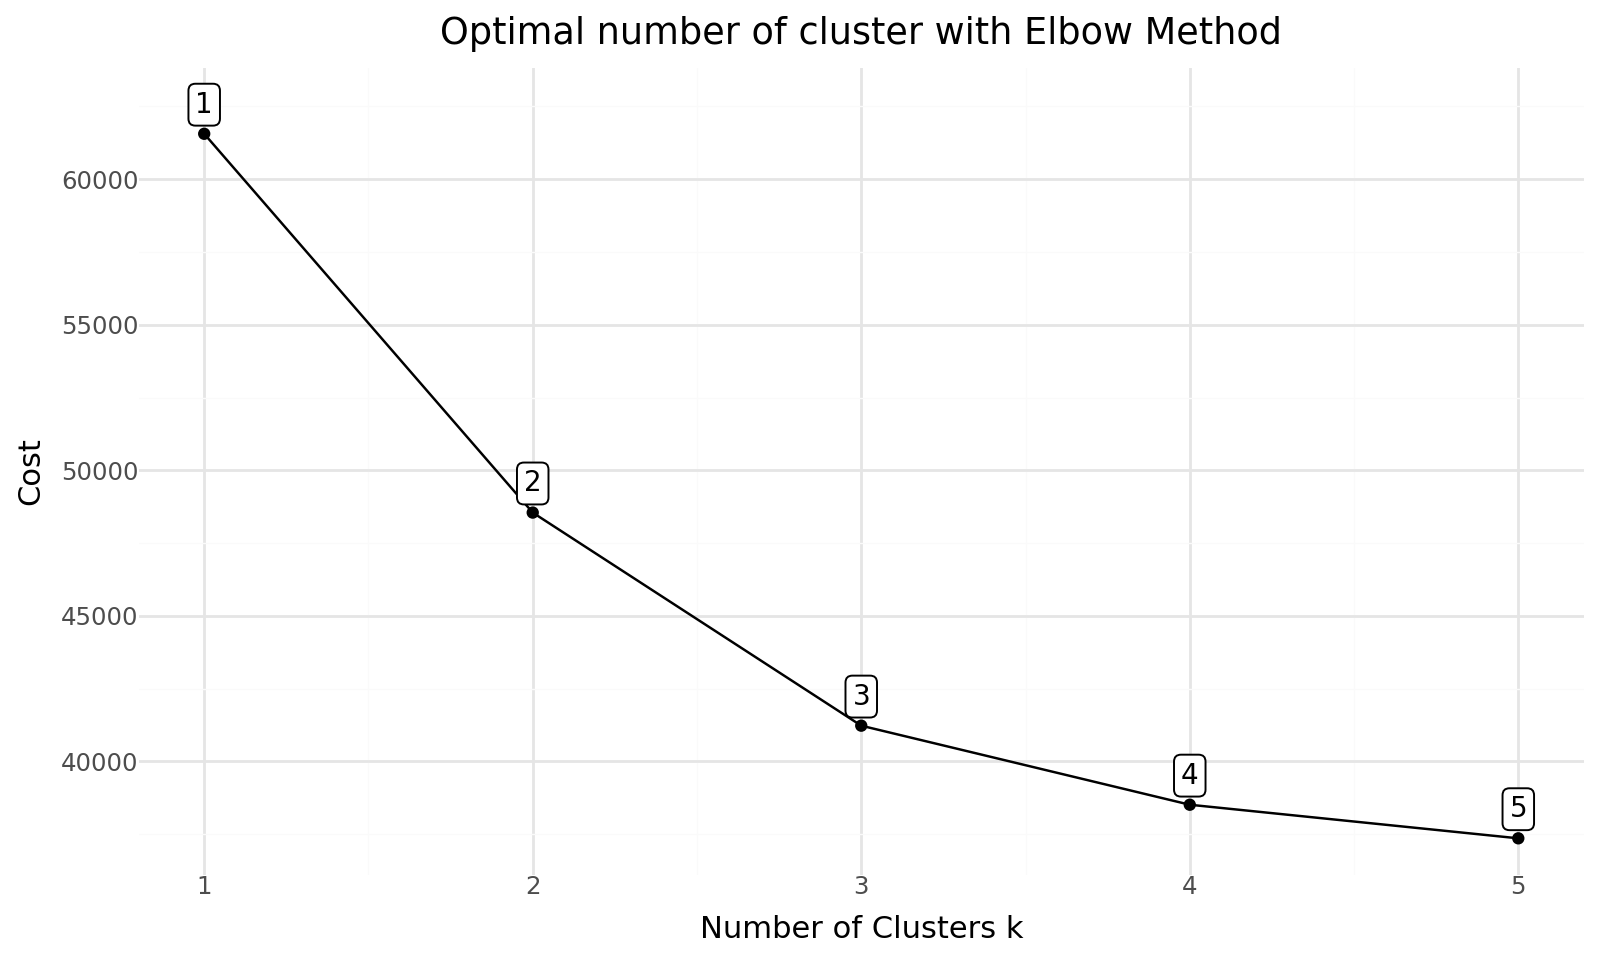

In [12]:
# aplicando kmodes
cost = []
t0 = time()
for cluster in range(1, 6): #variando k de 1 a 6
    try:
        kmodes = KModes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0) #calculando variação pra achar  o melhor valor de k
        kmodes.fit_predict(dfMatrix)
        cost.append(kmodes.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
        
print(f"concluido em {time() - t0:.3f} s")
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster': range(1, 6), 'Cost': cost})

# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

#3 é um bom valor nesse caso

In [14]:
# após escolher o valor de K é hora de rodar o modelo
t0 = time()
kmodes = KModes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kmodes.fit_predict(dfMatrix)
print(f"concluido em {time() - t0:.3f} s")

concluido em 2.014 s


In [15]:
# Adicionando o cluster no dataframe
df_cat['cluster'] = kmodes.labels_
df_cat['segmento'] = df_cat['cluster'].map({0:'Primeiro', 1:'Segundo', 2:'Terceiro'})
# Ordenando o cluster
df_cat['segmento'] = df_cat['segmento'].astype('category')
df_cat['segmento'] = df_cat['segmento'].cat.reorder_categories(['Primeiro', 'Segundo', 'Terceiro'])

In [19]:
df_cat

,id_cliente,genero,idoso,casado,dependentes,telefone,multiplas_linhas,internet,seguranca_online,backup_online,dispositivo_protegido,suporte_tecnico,streaming_tv,streaming_filmes,contrato,fatura_digital,metodo_pagamento,churn,cluster,segmento
0,7590-VHVEG,Female,No,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No,1,Segundo
1,5575-GNVDE,Male,No,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No,1,Segundo
2,3668-QPYBK,Male,No,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes,1,Segundo
3,7795-CFOCW,Male,No,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No,1,Segundo
4,9237-HQITU,Female,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes,1,Segundo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,No,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,No,2,Terceiro
7039,2234-XADUH,Female,No,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),No,2,Terceiro
7040,4801-JZAZL,Female,No,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,No,1,Segundo
7041,8361-LTMKD,Male,Yes,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,Yes,1,Segundo


In [20]:
#checando as modas e informações de cada cluster
kmodes.cluster_centroids_

array([['0023-UYUPN', 'Male', 'No', 'No', 'No', 'Yes', 'No', 'No',
        'No internet service', 'No internet service',
        'No internet service', 'No internet service',
        'No internet service', 'No internet service', 'Two year', 'No',
        'Mailed check', 'No'],
       ['0004-TLHLJ', 'Male', 'No', 'No', 'No', 'Yes', 'No',
        'Fiber optic', 'No', 'No', 'No', 'No', 'No', 'No',
        'Month-to-month', 'Yes', 'Electronic check', 'No'],
       ['0002-ORFBO', 'Female', 'No', 'Yes', 'No', 'Yes', 'Yes',
        'Fiber optic', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
        'Two year', 'Yes', 'Bank transfer (automatic)', 'No']],
      dtype='<U25')

In [17]:
#clusterização de textos
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")

In [15]:
#checando base de ados
df = pd.read_csv('c:/csv/news/NewsAggregatorDataset/newsCorpora.csv', header=None, sep="\t")
df.head()

,0,1,2,3,4,5,6,7
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [16]:
#adicionando os nomes das colunas
df.columns = ['id', 'text', 'link', 'jornal', 'categoria', 'fonte', 'site', 'meta']
df.head()

,id,text,link,jornal,categoria,fonte,site,meta
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [17]:
#selecionando parte das noticias (10000)
df_news = df.sample(n=10000)
df_news['categoria'].value_counts()#listando categorias

categoria
e    3558
b    2760
t    2627
m    1055
Name: count, dtype: int64

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

#vetorizando as palavras apartir de quantas vezes a palavra aparece no artigo com o quanto a palavra aparece na base de dados
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",#remove palavras que não possuem valor semantico
)

In [19]:
#gerando base de dados numerica
t0 = time()
X_tfidf = vectorizer.fit_transform(df_news.text)
print(f"vetorização completa em {time() - t0:.3f} s")
print(f"n_observacoes: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

vetorização completa em 0.092 s
n_observacoes: 10000, n_features: 3142
0.002


In [20]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA concluido em {time() - t0:.3f} s")
print(f"Variação explicado do SVD: {explained_variance * 100:.1f}%")

LSA concluido em 0.315 s
Variação explicado do SVD: 17.5%


In [21]:
#passando a base de dados pro k-means
for i in range(2,10):
    kmeans_model = KMeans(n_clusters=i, random_state=42).fit(X_lsa)
    labels = kmeans_model.labels_
    print(f"k={i} - silhueta={metrics.silhouette_score(X_lsa, labels, metric='euclidean'):.3f}")
    print(f"k={i} - rand_index={metrics.adjusted_rand_score(df_news.categoria.values, labels):.3f}")
    print(20*' * ')
#calculando metrica de silhueta e rand_index e comparando com o algoritmo    

k=2 - silhueta=0.019
k=2 - rand_index=0.001
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
k=3 - silhueta=0.023
k=3 - rand_index=0.241
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
k=4 - silhueta=0.025
k=4 - rand_index=0.103
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
k=5 - silhueta=0.032
k=5 - rand_index=0.118
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
k=6 - silhueta=0.037
k=6 - rand_index=0.277
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
k=7 - silhueta=0.039
k=7 - rand_index=0.114
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
k=8 - silhueta=0.045
k=8 - rand_index=0.119
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
k=9 - silhueta=0.048
k=9 - rand_index=0.085
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


In [22]:
#ira ser utilizado 4 grupos por já sabermos originalmente
kmeans = KMeans(
    n_clusters=4,
    max_iter=100,
    n_init=1,
    random_state=10,
).fit(X_lsa)

labels = kmeans.labels_

In [23]:
#checando quais grupos aparecem mais em cada cluster
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(4):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: google apple microsoft health day facebook study samsung million big 
Cluster 1: china says stocks bank billion rate ebola deal sales shares 
Cluster 2: video star 2014 dies death watch baby kim film kardashian 
Cluster 3: new york album trailer announces releases apple planet video app 


In [24]:
df_news.categoria.unique()

array(['e', 'm', 'b', 't'], dtype=object)

In [24]:
#clusterização multimidea 

import pandas as pd
import numpy as np
from sklearn import preprocessing

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid", palette="pastel")
%matplotlib inline

In [25]:
#tabelas de musicas de sucesso do spotify 2000-2019
df = pd.read_csv('c:/csv/spotify/songs_normalize.csv')
df.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop


In [26]:
#linhas e colunas
df.shape

(2000, 18)

In [27]:
#caracteristicas pra serem utilizadas no kmeans
caracteristicas = ['danceability', 'energy', 'key', 'loudness', 'mode', 
                   'speechiness', 'acousticness', 'instrumentalness', 
                   'liveness', 'valence', 'tempo',]

In [28]:
scaler = preprocessing.StandardScaler().fit(df[caracteristicas])
X_scaled = scaler.transform(df[caracteristicas])

In [29]:
#trazendo o kmeans e dbscan
from sklearn.cluster import KMeans, DBSCAN 
from sklearn import preprocessing, metrics
from itertools import permutations


x = df[caracteristicas].values 
min_max_scaler = preprocessing.MinMaxScaler()#transformando pra pesos de 0a 1
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled)

In [30]:
df_scaled.columns = caracteristicas

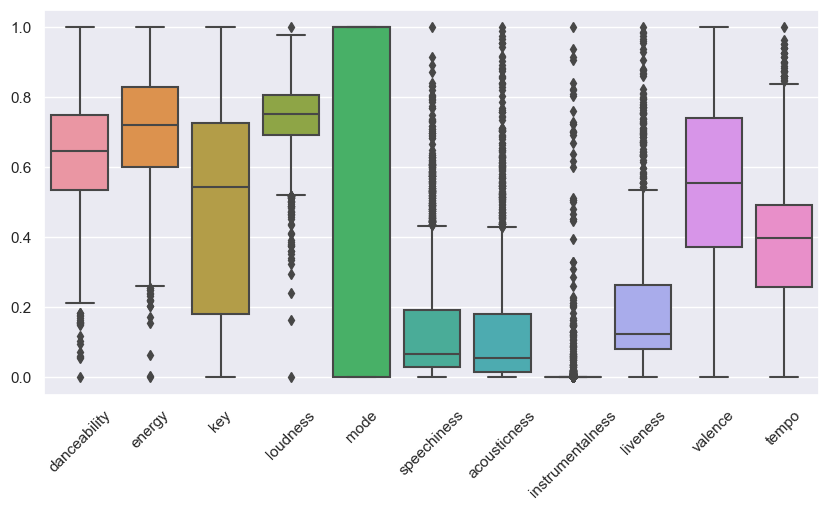

In [31]:
#visualizando as ditribuições dos dados
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_scaled)
ax.tick_params(axis='x', rotation=45);

#mode é binario 
#instrumentalness tem varios valores a cima da mediana

In [32]:
#1087 estão igual a 0 
df.instrumentalness.value_counts()

instrumentalness
0.000000    1087
0.001300       3
0.000108       3
0.000002       3
0.000139       3
            ... 
0.001090       1
0.000409       1
0.000009       1
0.000166       1
0.002440       1
Name: count, Length: 772, dtype: int64

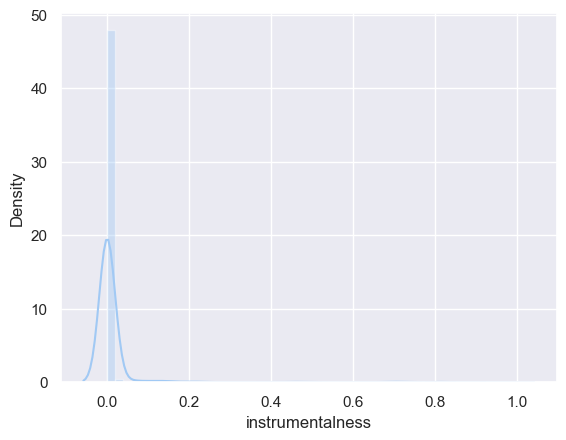

In [33]:
#distribuição dos valores
sns.distplot(df.instrumentalness);

In [34]:
#aplicando kmeans e observando a melhor silhueta
X_ = df_scaled.copy()
for i in range(2,10):
    kmeans_model = KMeans(n_clusters=i, 
                          random_state=42, 
                          max_iter=100).fit(X_)
    labels = kmeans_model.labels_
    silhueta = metrics.silhouette_score(X_, labels, metric='euclidean')
    print(f"k={i} - silhueta={silhueta:.3f}")
# 2 grupos foi a melhor 

k=2 - silhueta=0.385
k=3 - silhueta=0.287
k=4 - silhueta=0.221
k=5 - silhueta=0.209
k=6 - silhueta=0.194
k=7 - silhueta=0.171
k=8 - silhueta=0.160
k=9 - silhueta=0.146


In [35]:
db = DBSCAN(eps=.5, min_samples=7).fit(X_)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Número de Clusters: %d" % n_clusters_)
print("Número de Ruídos: %d" % n_noise_)

Número de Clusters: 2
Número de Ruídos: 47
